<a href="https://colab.research.google.com/github/SaakshiPandey/Burnout-Prediction/blob/main/Burnout_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving burnout_dataset_500.csv to burnout_dataset_500.csv


In [ ]:
!pip install xgboost imbalanced-learn shap

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

import joblib

In [ ]:
df = pd.read_csv("burnout_dataset_500.csv")
df.head()

,work_hours,sleep_quality,exercise_frequency,social_support,workload,job_satisfaction,stress_level,anxiety_level,mood,personal_life_satisfaction,burnout_score
0,58,5,4,6,3,3,3,2,6,6,46
1,44,6,5,9,5,8,8,6,6,3,34
2,37,3,0,2,8,5,2,4,1,8,63
3,50,4,0,1,2,7,1,3,1,6,47
4,48,9,4,2,6,4,9,2,3,2,60


In [ ]:
print('\n--- Dataframe info ---')
print(df.info())


print('\n--- Missing values per column ---')
print(df.isnull().sum())


print('\n--- Basic stats ---')
print(df.describe(include='all').T)


--- Dataframe info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   work_hours                  500 non-null    int64
 1   sleep_quality               500 non-null    int64
 2   exercise_frequency          500 non-null    int64
 3   social_support              500 non-null    int64
 4   workload                    500 non-null    int64
 5   job_satisfaction            500 non-null    int64
 6   stress_level                500 non-null    int64
 7   anxiety_level               500 non-null    int64
 8   mood                        500 non-null    int64
 9   personal_life_satisfaction  500 non-null    int64
 10  burnout_score               500 non-null    int64
dtypes: int64(11)
memory usage: 43.1 KB
None

--- Missing values per column ---
work_hours                    0
sleep_quality                 0
exercise_fre

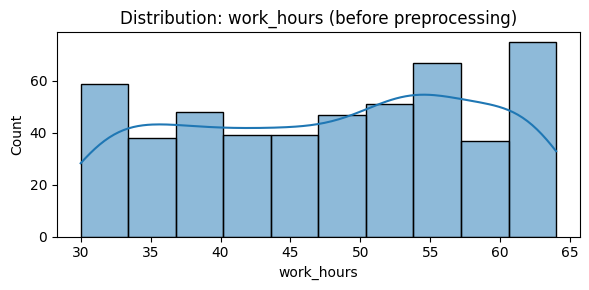

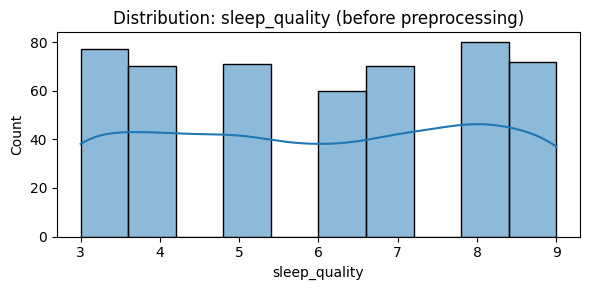

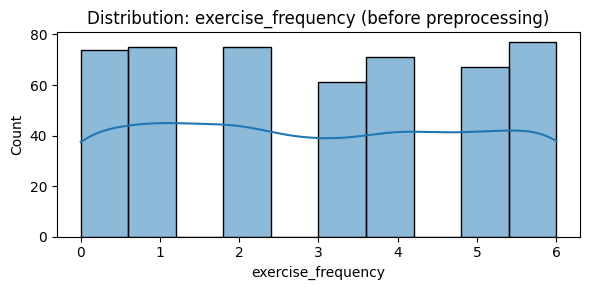

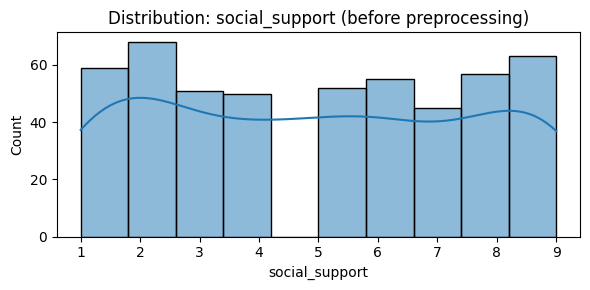

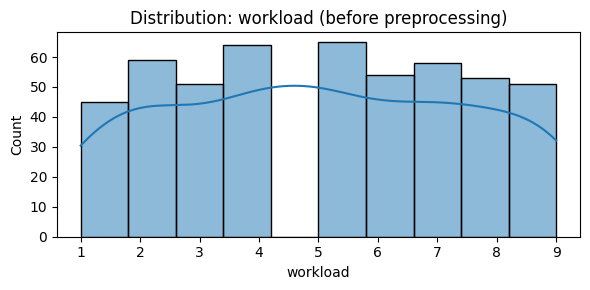

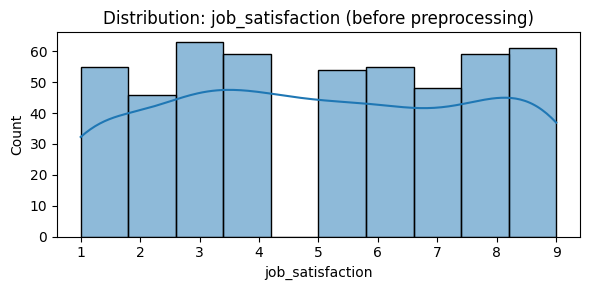

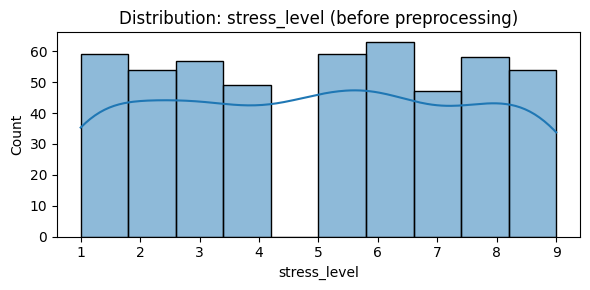

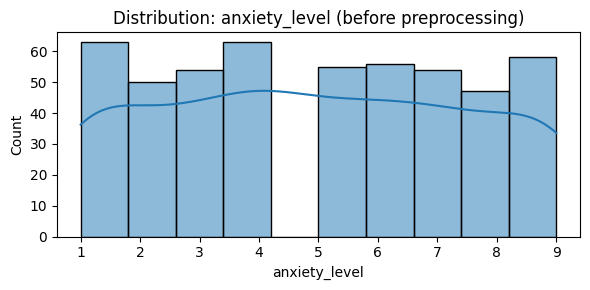

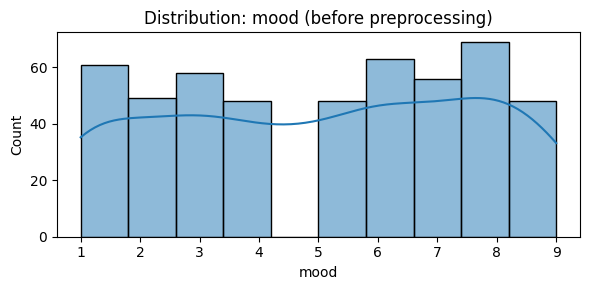

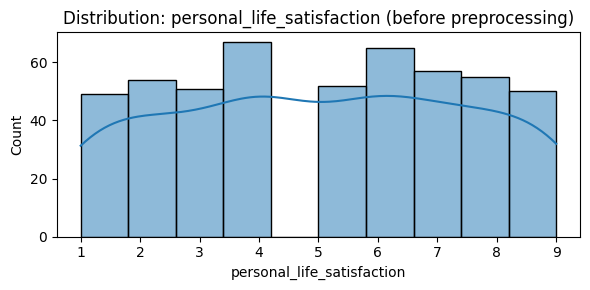

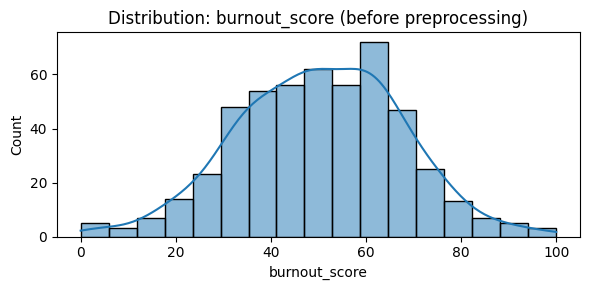

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


# Histograms
for col in num_cols:
  plt.figure(figsize=(6,3))
  sns.histplot(df[col].dropna(), kde=True)
  plt.title(f'Distribution: {col} (before preprocessing)')
  plt.tight_layout()
  plt.show()



In [ ]:
# ---------------- Cell 6: EDA - value counts for categorical columns ----------------
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    plt.figure(figsize=(8, 3))

    # Limit categories if there are too many unique values
    top_values = df[col].value_counts().nlargest(10).index  # show top 10 only
    sns.countplot(data=df[df[col].isin(top_values)], x=col, order=top_values)

    plt.title(f'Counts: {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


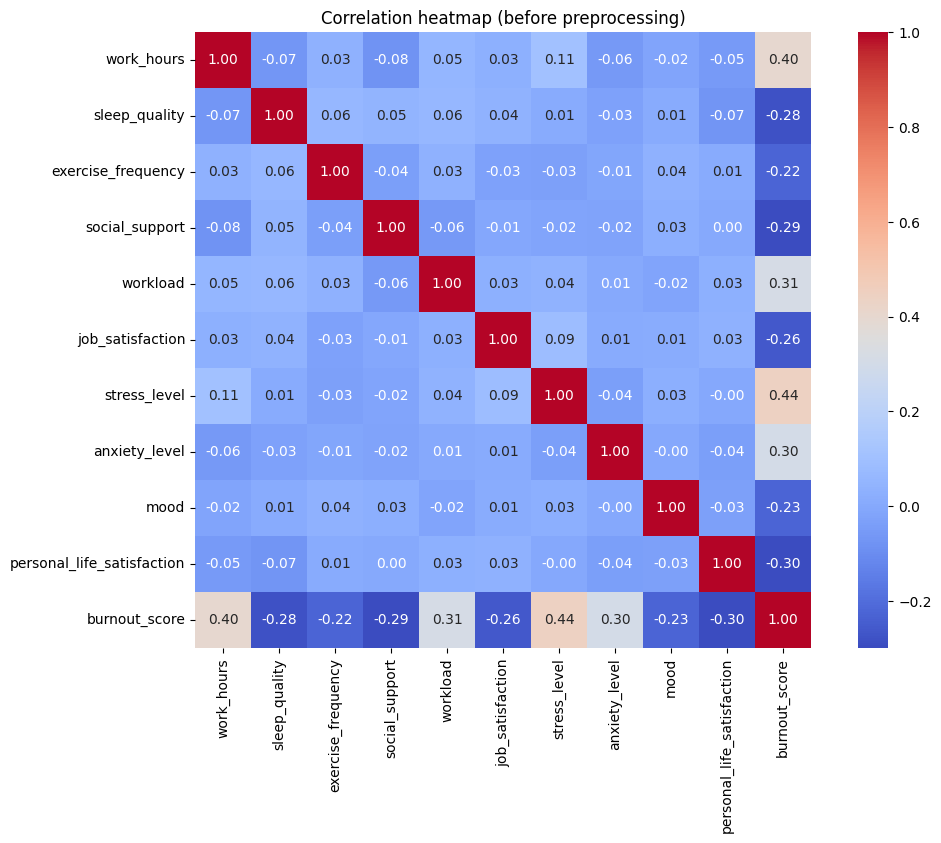

In [ ]:
# ---------------- Cell 7: Correlation heatmap (numerical) BEFORE preprocessing ----------------
plt.figure(figsize=(12,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation heatmap (before preprocessing)')
plt.show()

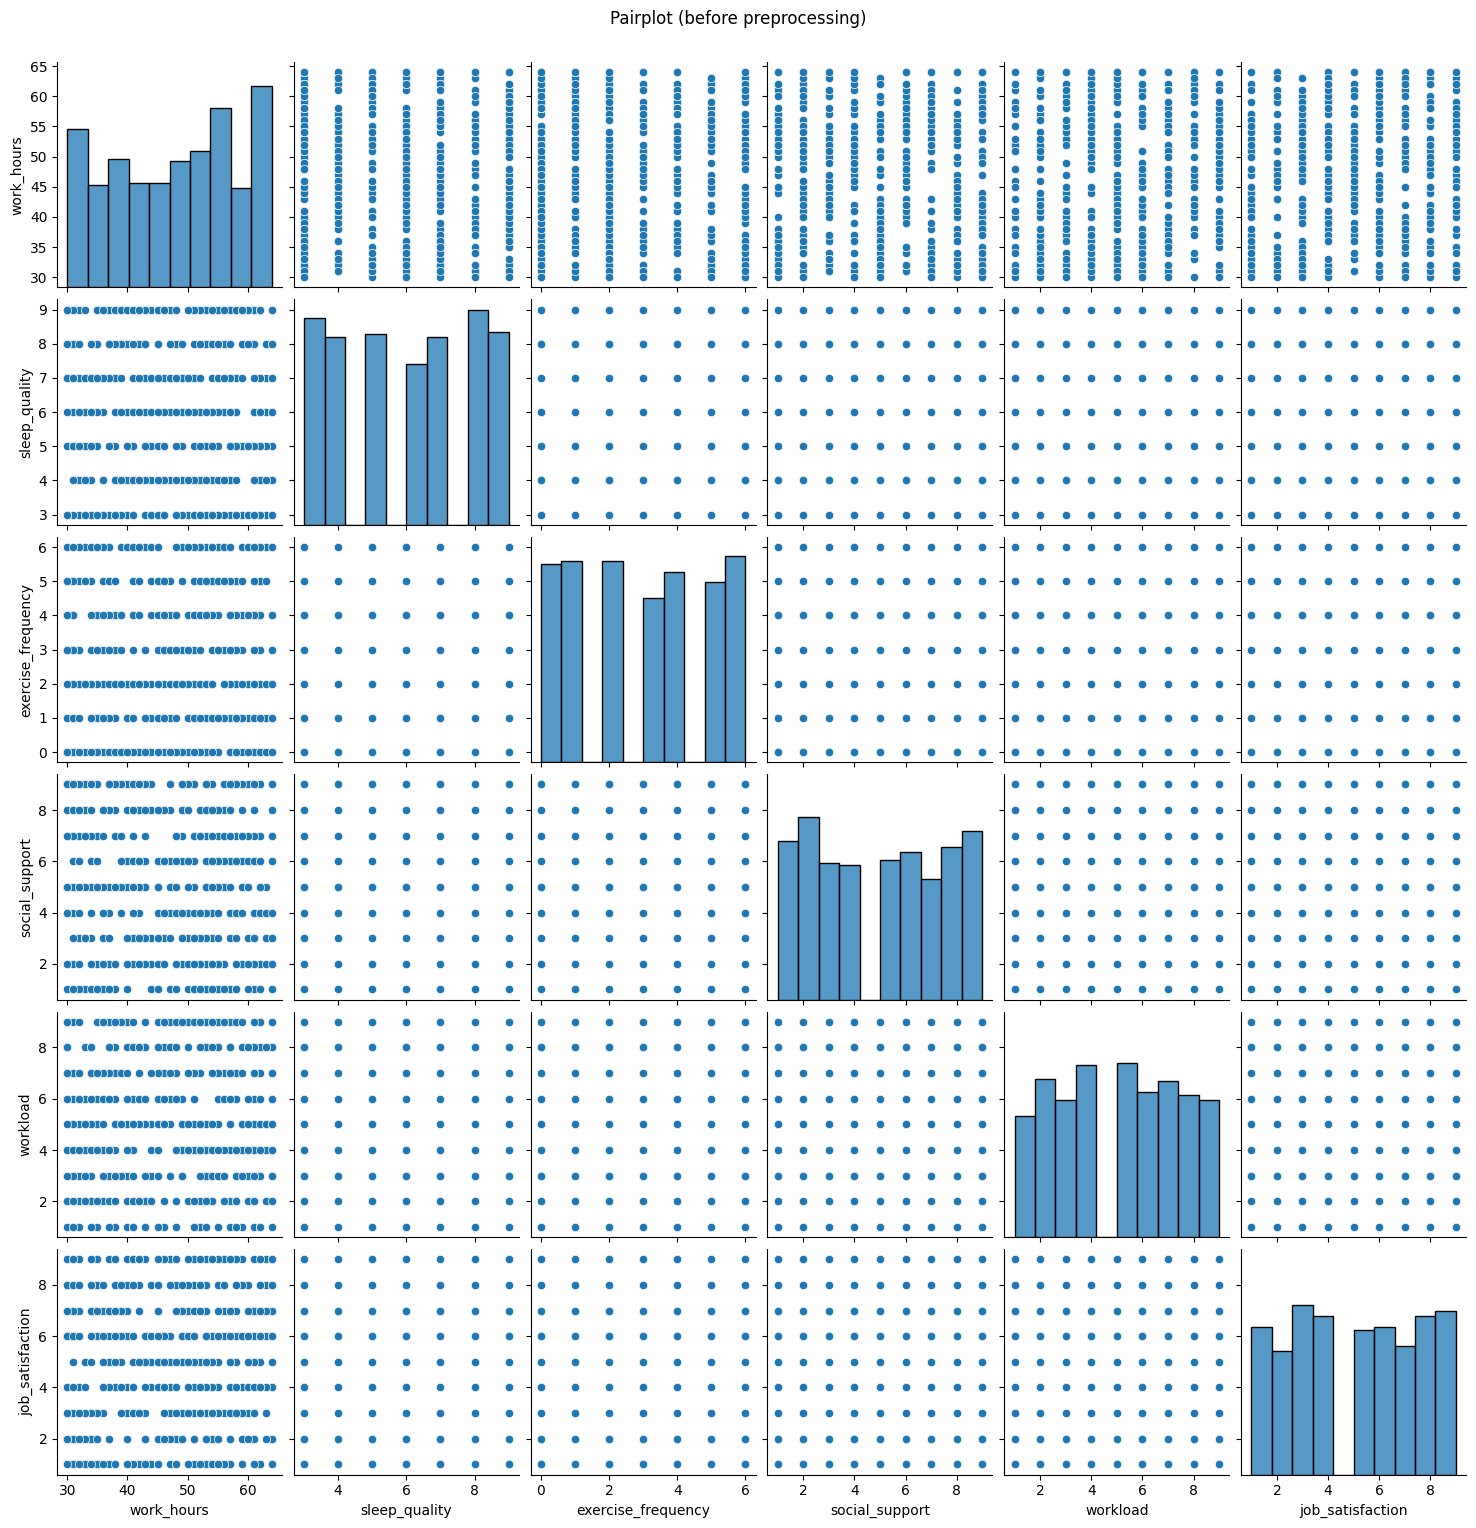

In [ ]:
# Pairplot (may be heavy if many features)
pairplot_cols = num_cols[:6] # change number as needed
sns.pairplot(df[pairplot_cols].dropna())
plt.suptitle('Pairplot (before preprocessing)', y=1.02)
plt.show()

In [ ]:
# 1) Missing value imputation: simple strategy per dtype
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df.head()

,work_hours,sleep_quality,exercise_frequency,social_support,workload,job_satisfaction,stress_level,anxiety_level,mood,personal_life_satisfaction,burnout_score
0,58,5,4,6,3,3,3,2,6,6,46
1,44,6,5,9,5,8,8,6,6,3,34
2,37,3,0,2,8,5,2,4,1,8,63
3,50,4,0,1,2,7,1,3,1,6,47
4,48,9,4,2,6,4,9,2,3,2,60


In [ ]:
# 2) Encoding

numeric_features = df_capped.select_dtypes(include=[np.number]).columns.drop(target_col).tolist()
categorical_features = df_capped.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# 3) Scaling: StandardScaler for numeric features
scaler = StandardScaler()

In [ ]:
# 4) Outlier handling - define a function to cap outliers by IQR


def cap_outliers_iqr(df_in, cols=None):
  df = df_in.copy()
  if cols is None:
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
  for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
  return df

In [ ]:
# 7) Balancing - SMOTE (for classification tasks)


# Let's create a preprocessing pipeline for numeric and categorical
numeric_transformer = Pipeline(steps=[
  ('imputer', num_imputer),
  ('scaler', scaler)
])


categorical_transformer = Pipeline(steps=[
  ('imputer', cat_imputer),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
  ])


# Apply outlier capping first
df_capped = cap_outliers_iqr(df)
print('Outliers capped. Shape:', df_capped.shape)

Outliers capped. Shape: (500, 11)


In [ ]:
print(df_capped.columns.tolist())


['work_hours', 'sleep_quality', 'exercise_frequency', 'social_support', 'workload', 'job_satisfaction', 'stress_level', 'anxiety_level', 'mood', 'personal_life_satisfaction', 'burnout_score']


In [ ]:
# ---------------- Cell 10: Apply preprocessing to create feature matrix X and target y ----------------
possible_targets = ['burnout_score', 'burnout', 'score', 'target']
cols = df_capped.columns.tolist()

target_col = None
for t in possible_targets:
    for c in cols:
        if t.lower() == c.lower():
            target_col = c
            break
    if target_col:
        break

if target_col is None:
    target_col = cols[-1]

print('✅ Using target column:', target_col)

# Identify numeric & categorical features (excluding target)
numeric_features = df_capped.select_dtypes(include=[np.number]).columns.drop(target_col).tolist()
categorical_features = df_capped.select_dtypes(include=['object', 'category']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Split into X and y
X_raw = df_capped.drop(columns=[target_col])
y_raw = df_capped[target_col]

# Apply preprocessing
X_pre = preprocessor.fit_transform(X_raw)

# Extract OneHot feature names if applicable
try:
    ohe_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
except Exception:
    ohe_features = []

feature_names = numeric_features + list(ohe_features)
X = pd.DataFrame(X_pre, columns=feature_names)

print('Processed X shape:', X.shape)


✅ Using target column: burnout_score
Numeric features: ['work_hours', 'sleep_quality', 'exercise_frequency', 'social_support', 'workload', 'job_satisfaction', 'stress_level', 'anxiety_level', 'mood', 'personal_life_satisfaction']
Categorical features: []
Processed X shape: (500, 10)


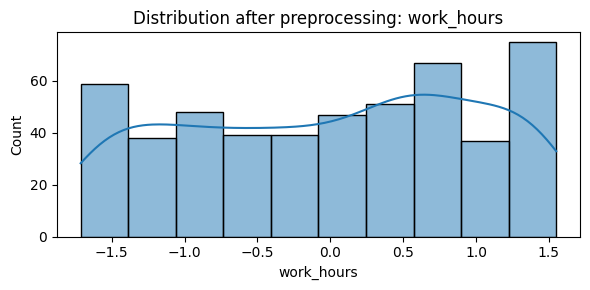

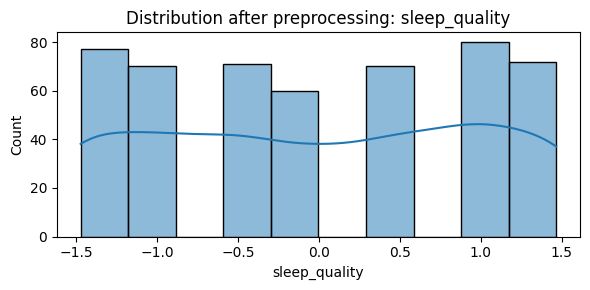

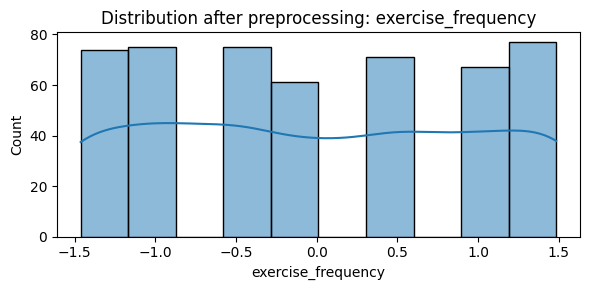

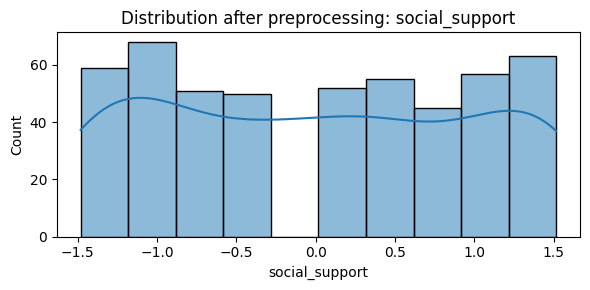

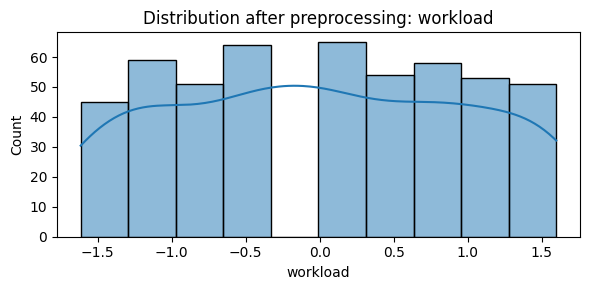

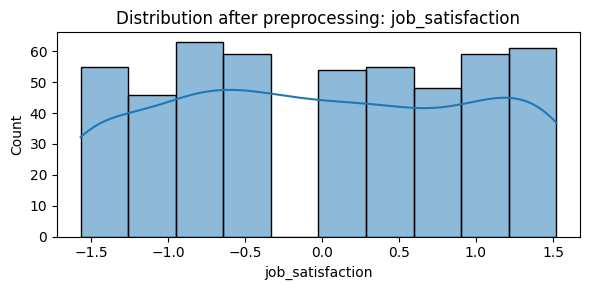

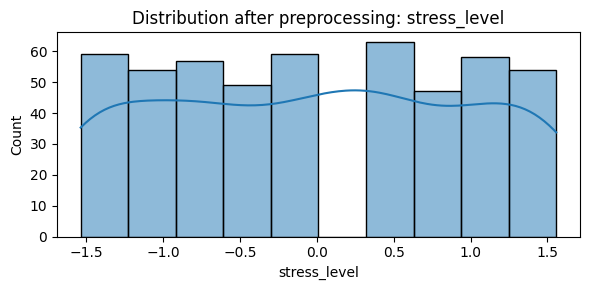

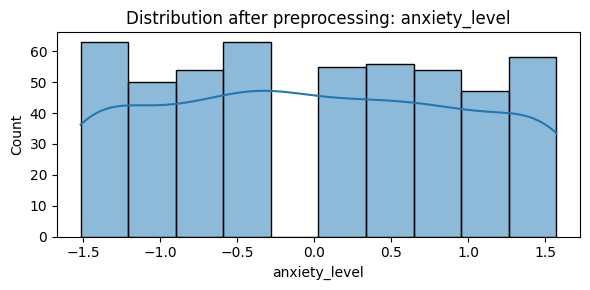

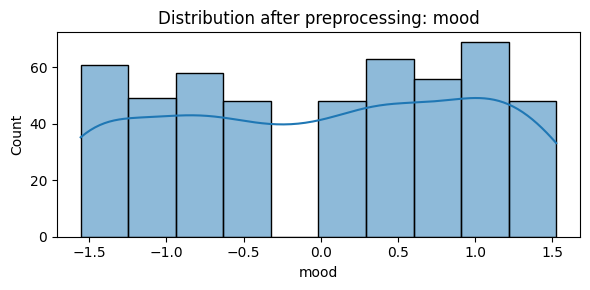

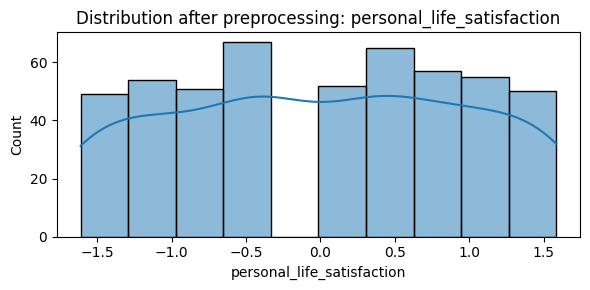

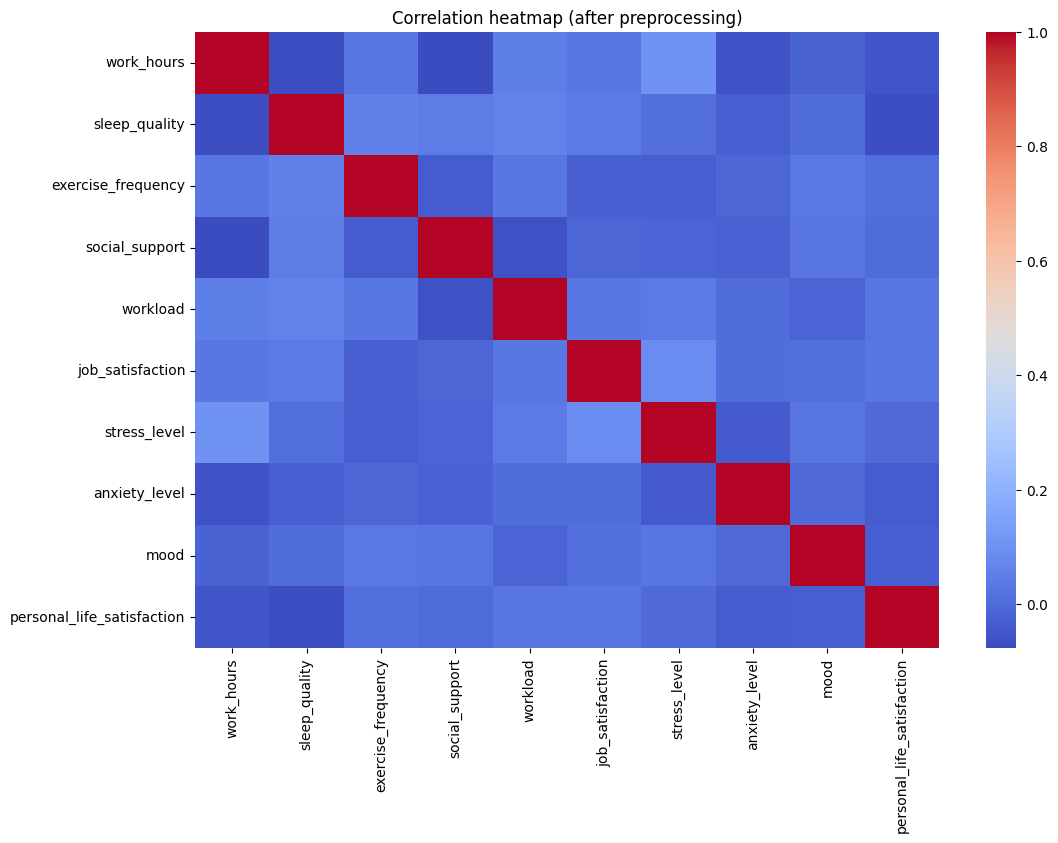

In [ ]:
for col in X.columns[:10]: # show first 10 to avoid overload
  plt.figure(figsize=(6,3))
  sns.histplot(X[col].dropna(), kde=True)
  plt.title(f'Distribution after preprocessing: {col}')
  plt.tight_layout()
  plt.show()


# Recompute correlation heatmap after preprocessing
plt.figure(figsize=(12,8))
cor2 = X.corr()
sns.heatmap(cor2, annot=False, cmap='coolwarm')
plt.title('Correlation heatmap (after preprocessing)')
plt.show()

In [ ]:
# Feature selection
# Select top-k features most correlated with target (for regression task)
if pd.api.types.is_numeric_dtype(y_raw):
  corr_with_target = pd.concat([X, y_raw.reset_index(drop=True)], axis=1).corr()[target_col].abs().sort_values(ascending=False)
  # drop target entry
  corr_with_target = corr_with_target.drop(labels=[col for col in corr_with_target.index if col not in X.columns], errors='ignore')
  top_features = corr_with_target.index[1:11].tolist() if len(corr_with_target) > 1 else X.columns.tolist()
  print('Top features correlated with target:', top_features)
else:
  top_features = X.columns[:10].tolist()

Top features correlated with target: ['work_hours', 'workload', 'anxiety_level', 'personal_life_satisfaction', 'social_support', 'sleep_quality', 'job_satisfaction', 'mood', 'exercise_frequency']


In [ ]:
# Split data for regression and classification
X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size=0.2, random_state=42)


# For classification create binary target
if pd.api.types.is_numeric_dtype(y_raw):
  median = y_raw.median()
  y_class = (y_raw >= median).astype(int)
else:
  y_class = y_raw.copy()


Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y_class, test_size=0.2, random_state=42)


print('Regression shapes:', X_train.shape, X_test.shape)
print('Classification shapes:', Xc_train.shape, Xc_test.shape)


# Apply SMOTE if imbalance exists and SMOTE available
if SMOTE is not None:
  print('SMOTE available. Class distribution before:', np.bincount(yc_train))
  try:
    sm = SMOTE(random_state=42)
    Xc_train_res, yc_train_res = sm.fit_resample(Xc_train, yc_train)
    print('After SMOTE:', np.bincount(yc_train_res))
  except Exception as e:
    print('SMOTE failed:', e)
    Xc_train_res, yc_train_res = Xc_train, yc_train
else:
  print('SMOTE not installed; continuing without balancing')
  Xc_train_res, yc_train_res = Xc_train, yc_train

Regression shapes: (400, 10) (100, 10)
Classification shapes: (400, 10) (100, 10)
SMOTE available. Class distribution before: [199 201]
After SMOTE: [201 201]


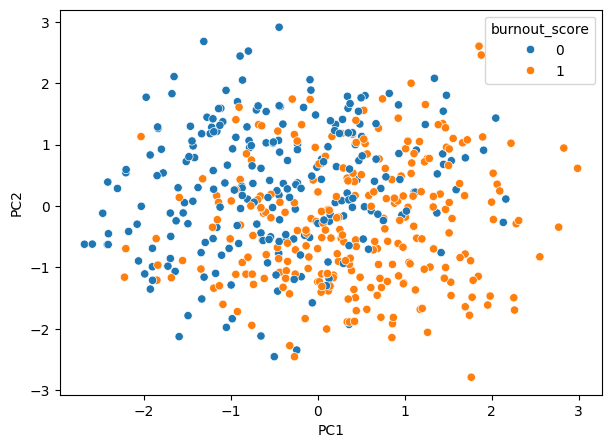

In [ ]:
#  Dimensionality reduction for visualization (2D)
pca2 = PCA(n_components=2, random_state=42)
X_vis = pca2.fit_transform(X)
X_vis_df = pd.DataFrame(X_vis, columns=['PC1','PC2'])
X_vis_df[target_col] = y_class.values


plt.figure(figsize=(7,5))
if y_class.nunique() <= 10:
  sns.scatterplot(data=X_vis_df, x='PC1', y='PC2', hue=target_col, palette='tab10')
else:
  plt.scatter(X_vis_df['PC1'], X_vis_df['PC2'], c=X_vis_df[target_col])
  plt.title('Decision region approx (PCA 2 components)')
  plt.show()

LinearRegression --> RMSE: 5.2149, MAE: 4.2483, R2: 0.8825


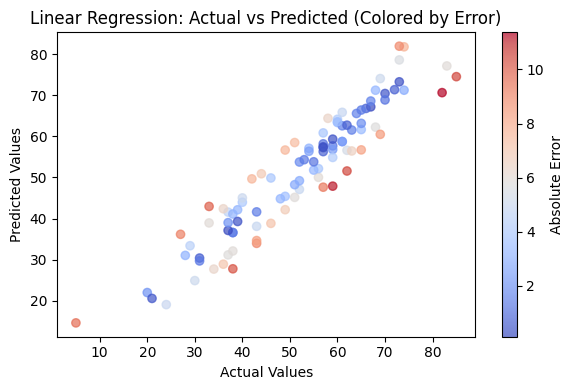

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f'LinearRegression --> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

# Plot: Predicted vs Actual (colored by error)
errors = abs(y_test - y_pred_lr)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_lr, c=errors, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Absolute Error')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted (Colored by Error)")
plt.tight_layout()
plt.show()


RandomForestRegressor --> RMSE: 8.4438, MAE: 6.5998, R2: 0.6918


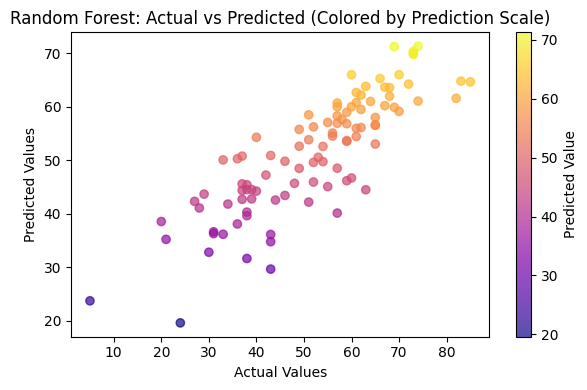

In [ ]:
#  Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
mae = mean_absolute_error(y_test, y_pred_rfr)
r2 = r2_score(y_test, y_pred_rfr)

print(f'RandomForestRegressor --> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rfr, c=y_pred_rfr, cmap='plasma', alpha=0.7)
plt.colorbar(label='Predicted Value')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted (Colored by Prediction Scale)")
plt.tight_layout()
plt.show()




LogisticRegression --> Acc: 0.9200, Prec: 0.9483, Rec: 0.9167, F1: 0.9322, ROC_AUC: 0.9829


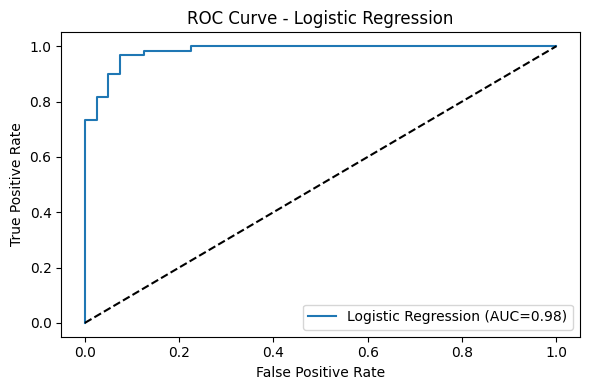

In [ ]:
# ---------------- Cell 16A: Logistic Regression ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

logr = LogisticRegression(max_iter=1000)
logr.fit(Xc_train_res, yc_train_res)
yc_pred_logr = logr.predict(Xc_test)
yc_pred_prob_logr = logr.predict_proba(Xc_test)[:,1]

acc = accuracy_score(yc_test, yc_pred_logr)
prec = precision_score(yc_test, yc_pred_logr)
rec = recall_score(yc_test, yc_pred_logr)
f1 = f1_score(yc_test, yc_pred_logr)
roc = roc_auc_score(yc_test, yc_pred_prob_logr)

print(f"LogisticRegression --> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, ROC_AUC: {roc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(yc_test, yc_pred_prob_logr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={roc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()

RandomForestClassifier --> Acc: 0.8500, Prec: 0.9091, Rec: 0.8333, F1: 0.8696, ROC_AUC: 0.9381


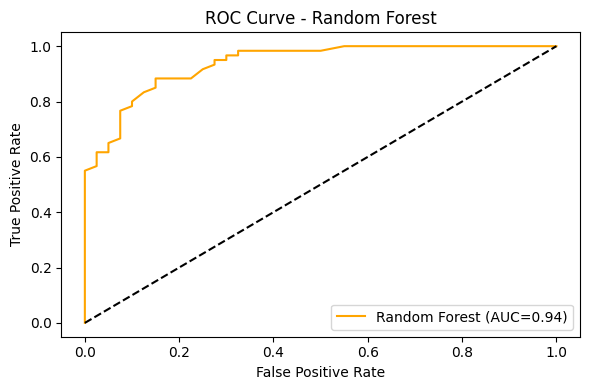

In [ ]:
# ---------------- Cell 16B: Random Forest Classifier ----------------
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(Xc_train_res, yc_train_res)
yc_pred_rfc = rfc.predict(Xc_test)
yc_pred_prob_rfc = rfc.predict_proba(Xc_test)[:,1]

acc = accuracy_score(yc_test, yc_pred_rfc)
prec = precision_score(yc_test, yc_pred_rfc)
rec = recall_score(yc_test, yc_pred_rfc)
f1 = f1_score(yc_test, yc_pred_rfc)
roc = roc_auc_score(yc_test, yc_pred_prob_rfc)

print(f"RandomForestClassifier --> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, ROC_AUC: {roc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(yc_test, yc_pred_prob_rfc)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='orange', label=f'Random Forest (AUC={roc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()


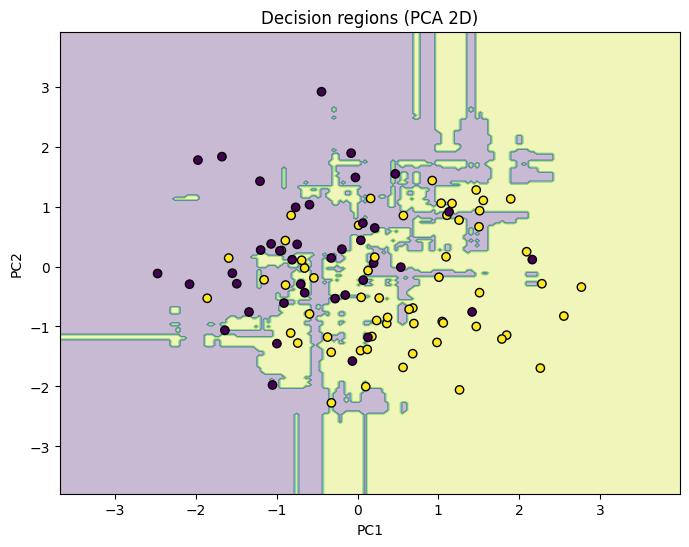

In [ ]:
#  Decision region plotting (approx using PCA 2 components) )
from matplotlib.colors import ListedColormap


clf = rfc # using random forest classifier trained earlier


# Prepare PCA 2d for train and test
Xc_pca = pca2.transform(X)
Xc_pca_train, Xc_pca_test, y_pca_train, y_pca_test = train_test_split(Xc_pca, y_class, test_size=0.2, random_state=42)


# Fit classifier on PCA features (for visualization only)
clf_vis = RandomForestClassifier(n_estimators=100, random_state=42)
clf_vis.fit(Xc_pca_train, y_pca_train)


x_min, x_max = Xc_pca[:,0].min() - 1, Xc_pca[:,0].max() + 1
y_min, y_max = Xc_pca[:,1].min() - 1, Xc_pca[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = clf_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(Xc_pca_test[:,0], Xc_pca_test[:,1], c=y_pca_test, edgecolor='k')
plt.title('Decision regions (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

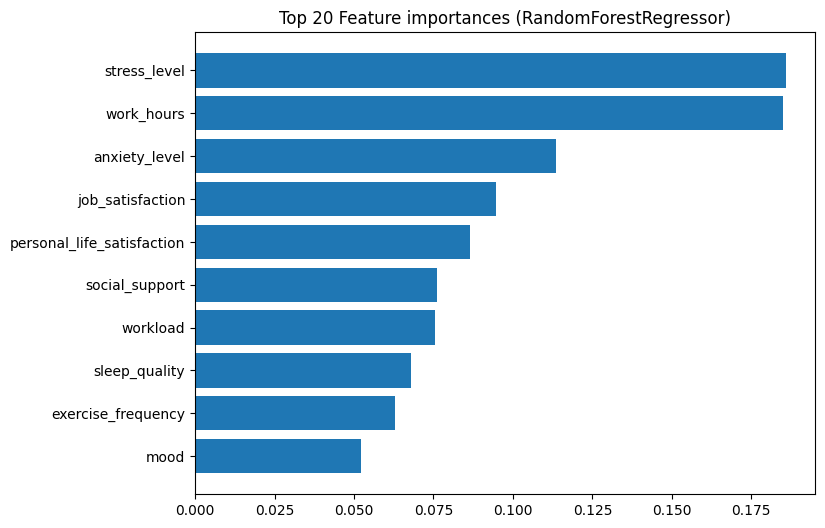

In [ ]:
# ---------------- Cell 19: Feature importance (for tree-based models) ----------------
importances = rfr.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(8,6))
plt.title('Top 20 Feature importances (RandomForestRegressor)')
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.show()

In [ ]:
def predict_burnout_from_dict(input_dict):

  x_df = pd.DataFrame([input_dict])
  # Ensure all columns present
  for col in X_raw.columns:
    if col not in x_df.columns:
      x_df[col] = np.nan
  x_df = x_df[X_raw.columns]
  # preprocess
  X_proc = preprocessor.transform(x_df)
  X_proc_df = pd.DataFrame(X_proc, columns=feature_names)
  # regression
  score_lr = lr.predict(X_proc_df)[0]
  score_rfr = rfr.predict(X_proc_df)[0]
  score = np.mean([score_lr, score_rfr] + ([xgbr.predict(X_proc_df)[0]] if xgbr is not None else []))
  # classification
  class_prob = rfc.predict_proba(X_proc_df)[0][1]
  class_pred = int(class_prob >= 0.5)
  return {'regression_score': float(score), 'class_pred': int(class_pred), 'class_prob': float(class_prob)}

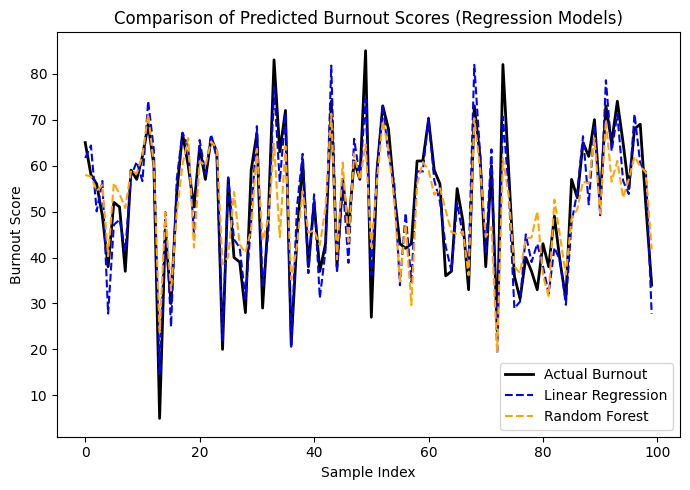

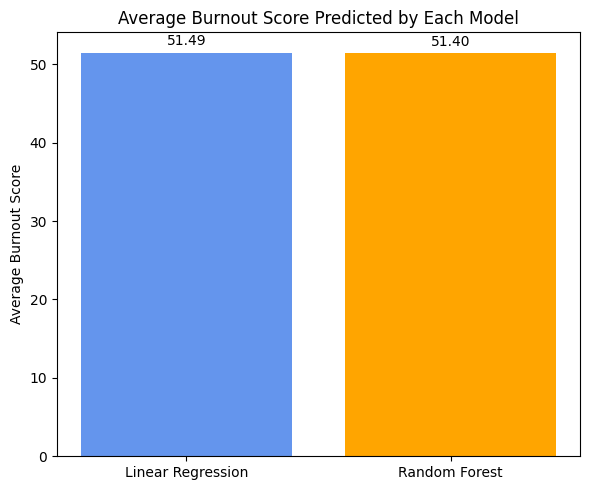

In [ ]:
# Compare predicted burnout scores from different models

plt.figure(figsize=(7,5))

plt.plot(y_test.values, label='Actual Burnout', color='black', linewidth=2)
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='blue')
plt.plot(y_pred_rfr, label='Random Forest', linestyle='--', color='orange')

plt.xlabel('Sample Index')
plt.ylabel('Burnout Score')
plt.title('Comparison of Predicted Burnout Scores (Regression Models)')
plt.legend()
plt.tight_layout()
plt.show()


avg_scores = [
    np.mean(y_pred_lr),
    np.mean(y_pred_rfr)
]

models = ['Linear Regression', 'Random Forest']

if 'y_pred_logr' in locals():
    avg_scores.append(np.mean(y_pred_logr))
    models.append('Logistic Regression')

plt.figure(figsize=(6,5))
bars = plt.bar(models, avg_scores, color=['#6495ED', '#FFA500', '#00C49F'][:len(models)])
plt.title('Average Burnout Score Predicted by Each Model')
plt.ylabel('Average Burnout Score')
plt.bar_label(bars, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

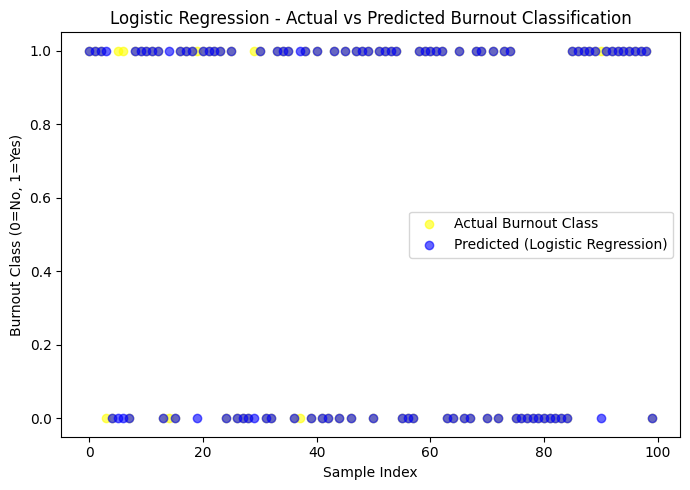

In [ ]:
# Logistic Regression - Actual vs Predicted
plt.figure(figsize=(7,5))

plt.scatter(range(len(yc_test)), yc_test, color='yellow', label='Actual Burnout Class', alpha=0.6)
plt.scatter(range(len(yc_pred_logr)), yc_pred_logr, color='blue', label='Predicted (Logistic Regression)', alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Burnout Class (0=No, 1=Yes)')
plt.title('Logistic Regression - Actual vs Predicted Burnout Classification')
plt.legend()
plt.tight_layout()
plt.show()
